## Imports

In [1]:
import torch
print(torch.cuda.is_bf16_supported()) # Should be True

True


In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
from torchvision.transforms import v2

In [3]:
import spoofdet.config as config
from spoofdet.efficient_net.model_utils import get_transform_pipeline, evaluate_model, train_model, checkImage, checkAugmentedImage, create_subset, checkDatasetDistribution, display_train_result, save_results, analyze_spoof_types, analyze_dataset_spoof_distribution, split_celeba_json_by_subject, display_params, verify_subject_split
from spoofdet.dataset import CelebASpoofDataset

## randomizer

In [4]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

## params

In [5]:
import multiprocessing
from torch.utils.data import Subset

PARAM_MULTIPLIER = 1

MODEL_NAME = "efficientnet_v2_s"
BATCH_SIZE= 32 * PARAM_MULTIPLIER


EPOCHS = 100
EARLY_STOPPING_LIMIT = config.EARLY_STOPPING_LIMIT
TARGET_SIZE = 384
#TARGET_SIZE = config.TARGET_SIZE
LEARNING_RATE = 1e-3 * PARAM_MULTIPLIER

BACKBONE_LR = 1e-5
HEAD_LR = 1e-3  
WEIGHT_DECAY = 5e-2 * PARAM_MULTIPLIER


NUM_UNFROZEN_LAYERS = 3



WORKERS = 2

SPOOF_PERCENT = 0.5
TRAIN_IMG_COUNT = 10000
VAL_IMG_COUNT = int(TRAIN_IMG_COUNT * 0.2)  
# VAL_IMG_COUNT = 1000
TEST_IMG_COUNT = int(TRAIN_IMG_COUNT * 0.1)  
    # 0.001


## Model


In [6]:
model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)

for param in model.features.parameters():
    param.requires_grad = False

# Adjust the final layer for 2 classes (Live/Spoof)
# EfficientNet uses .classifier instead of .fc
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 2)


for layer in list(model.features.children())[-NUM_UNFROZEN_LAYERS:]:
        for param in layer.parameters():
            param.requires_grad = True



## preparation


In [7]:
import multiprocessing
from torch.utils.data import Subset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
bbox_lookup = "../bbox_lookup.json"
num_cpus = multiprocessing.cpu_count()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW([
    {'params': model.features.parameters(), 'lr': BACKBONE_LR},
    {'params': model.classifier.parameters(), 'lr': HEAD_LR},
    
], weight_decay=WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
device

device(type='cuda')

In [8]:
gpu_transforms_train, gpu_transforms_val = get_transform_pipeline(device=device, target_size=TARGET_SIZE)

In [9]:


all_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=config.TRAIN_JSON,
    bbox_json_path=bbox_lookup,
    target_size = TARGET_SIZE,
    bbox_original_size = config.BBOX_ORGINAL_SIZE
)

test_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=config.TEST_JSON,
    bbox_json_path=bbox_lookup,
    target_size = TARGET_SIZE,
    bbox_original_size = config.BBOX_ORGINAL_SIZE
)


t_idx, v_idx = split_celeba_json_by_subject(config.TRAIN_JSON)
train_ds = Subset(all_ds, t_idx)
val_ds = Subset(all_ds, v_idx)

Loading BBox Cache into RAM...
Loading BBox Cache into RAM...


In [10]:
verify_subject_split(all_ds, t_idx, v_idx)


Subject Split Verification:
Training Subjects:   4096
Validation Subjects: 4096
Overlapping Subjects: 0

✓ SUCCESS: No subject leakage detected
Train and validation sets are completely disjoint



True

In [11]:
len(train_ds)

247020

In [12]:

np.random.seed(seed)

small_train_ds = create_subset(train_ds.dataset, total_size=TRAIN_IMG_COUNT, spoof_percent=SPOOF_PERCENT)
small_val_ds = create_subset(val_ds.dataset, total_size=VAL_IMG_COUNT, spoof_percent=SPOOF_PERCENT)
small_test_ds = create_subset(test_ds, total_size=TEST_IMG_COUNT)
print(f"Created Balanced Train: {len(small_train_ds)} images")

 Scanning specific indices for class balance...
 Found in this split: 162462 Live | 331943 Spoof
 Scanning specific indices for class balance...
 Found in this split: 162462 Live | 331943 Spoof
 Scanning specific indices for class balance...
 Found in this split: 19923 Live | 47247 Spoof
Created Balanced Train: 10000 images


In [13]:
len(small_train_ds)

10000

In [14]:
len(small_val_ds)

2000

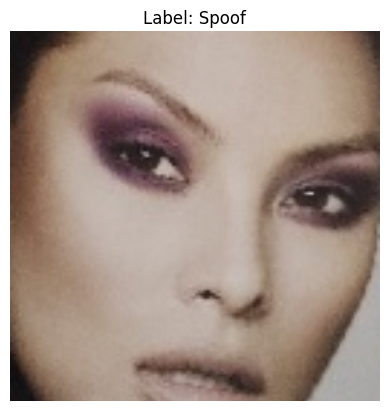

In [15]:

# 1 = spoof  0 = live 
checkImage(small_train_ds, 210)

In [16]:
# check distribution of live and spoof in small_test_ds
# checkDatasetDistribution(small_test_ds)

In [17]:
# checkDatasetDistribution(small_train_ds)

In [18]:
# checkDatasetDistribution(small_val_ds)

## Data Loader

In [19]:
from torch.utils.data import DataLoader
small_train_loader = DataLoader(small_train_ds, 
                                batch_size=BATCH_SIZE, 
                                shuffle=True,
                                num_workers=WORKERS,
                                pin_memory=True,
                                persistent_workers=True
          
                   
)
small_val_loader = DataLoader(small_val_ds, 
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=WORKERS,
                              pin_memory=True,
                              persistent_workers=True
                

)
small_test_loader = DataLoader(small_test_ds, 
                               batch_size=BATCH_SIZE, 
                               shuffle=False,
                                num_workers=WORKERS,
                                pin_memory=True,
                                persistent_workers=True
                                )

In [20]:
sample_img, sample_label = small_train_ds[0]
sample_img.shape, sample_label

(torch.Size([3, 384, 384]), tensor(0))

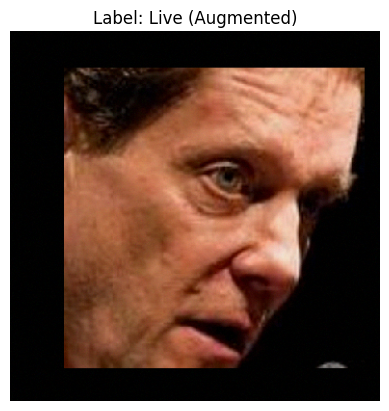

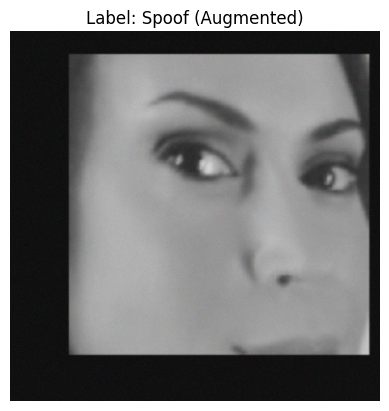

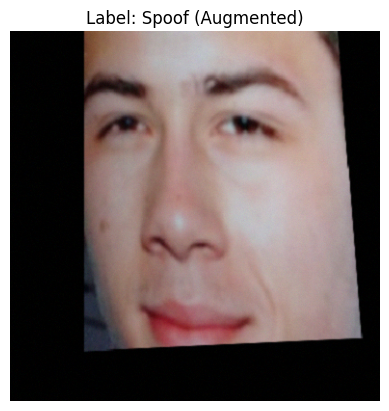

In [21]:
for i in range(3):
    checkAugmentedImage(small_train_ds, i, gpu_transforms=gpu_transforms_train)

In [22]:
params = display_params(model_name=MODEL_NAME,lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, batch_size=BATCH_SIZE, epochs=EPOCHS, early_stopping_limit=EARLY_STOPPING_LIMIT,target_size=TARGET_SIZE, train_size=TRAIN_IMG_COUNT, val_size=VAL_IMG_COUNT,  num_unfrozen_layers=NUM_UNFROZEN_LAYERS, backbone_lr=BACKBONE_LR, head_lr=HEAD_LR)

Training Configuration:
 Model Name: efficientnet_v2_s
 Batch Size: 32
 Learning Rate: 0.001
 Weight Decay: 0.05
 Epochs: 100
 Early Stopping Limit: 30
 Target Size: 384
 Train Size: 10000
 Validation Size: 2000
 Unfrozen Layers: 3
 Backbone LR: 1e-05
 Head LR: 0.001


## Train

In [23]:
model, history = train_model(model=model, 
                             device=device, 
                             train_loader=small_train_loader, 
                             val_loader=small_val_loader,      
                             criterion=criterion, 
                             optimizer=optimizer, 
                             epochs=EPOCHS,
                             early_stopping_limit=config.EARLY_STOPPING_LIMIT,
                             train_transforms=gpu_transforms_train,
                             val_transforms=gpu_transforms_val,
                             profiler_log_name=MODEL_NAME,
                             scheduler=scheduler
                             )

Epoch [1/100] | Time: 2m 8s Train Loss: 0.1943 | Val Loss: 0.1926 | Val Precision: 99.43% | Val Accuracy: 93.55% | Val Recall: 87.60% | Val F1: 93.14%
Scheduler Step! New LR: 0.00001000  -> New best model saved!
Epoch [2/100] | Time: 1m 22s Train Loss: 0.1169 | Val Loss: 0.4956 | Val Precision: 100.00% | Val Accuracy: 85.95% | Val Recall: 71.90% | Val F1: 83.65%
Scheduler Step! New LR: 0.00000999  -> No improvement. Counter: 1/30
Epoch [3/100] | Time: 1m 20s Train Loss: 0.0895 | Val Loss: 0.1619 | Val Precision: 99.34% | Val Accuracy: 95.20% | Val Recall: 91.00% | Val F1: 94.99%
Scheduler Step! New LR: 0.00000998  -> New best model saved!
Epoch [4/100] | Time: 1m 26s Train Loss: 0.0718 | Val Loss: 0.1768 | Val Precision: 99.55% | Val Accuracy: 94.25% | Val Recall: 88.90% | Val F1: 93.92%
Scheduler Step! New LR: 0.00000996  -> No improvement. Counter: 1/30
Epoch [5/100] | Time: 1m 27s Train Loss: 0.0661 | Val Loss: 0.1018 | Val Precision: 99.36% | Val Accuracy: 96.45% | Val Recall: 93.5

D:\JoshFile\Github\spoofing-recognition\src\spoofdet\efficient_net\model_utils.py:432: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_loss.show()
D:\JoshFile\Github\spoofing-recognition\src\spoofdet\efficient_net\model_utils.py:442: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_precision.show()


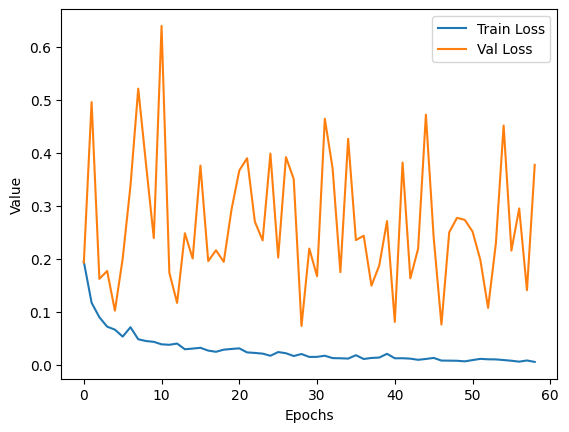

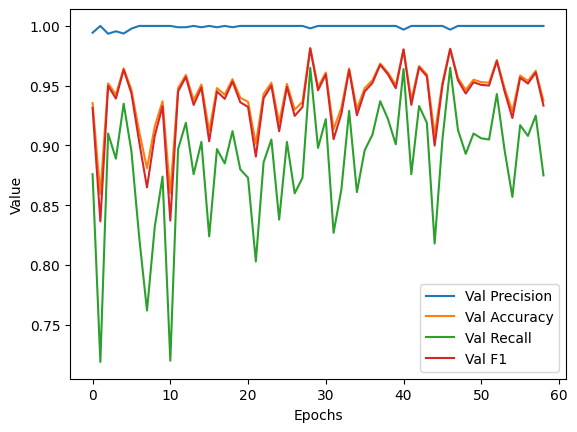

In [24]:




train_loss_fig, precision_fig = display_train_result(history)

## test


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live           498     |          2
Spoof          146     |        354


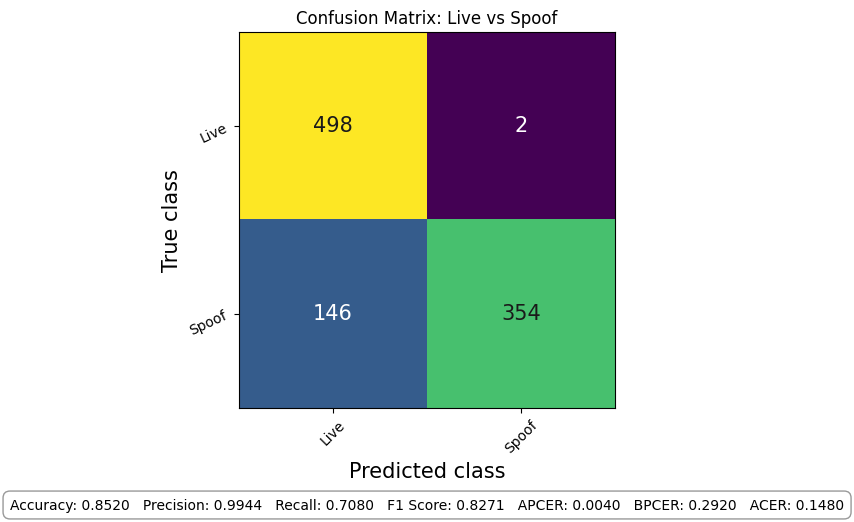

Accuracy: 0.8520
Precision: 0.9944
Recall:    0.7080
F1 Score:  0.8271
Spoofing Metrics: APCER: 0.0040, BPCER: 0.2920, ACER: 0.1480


In [ ]:
confusion_matrix, accuracy, precision, recall, f1, spoof_metric_val  = evaluate_model(model=model, dataloader=small_test_loader, device=device, val_transforms=gpu_transforms_val, threshold=0.5)

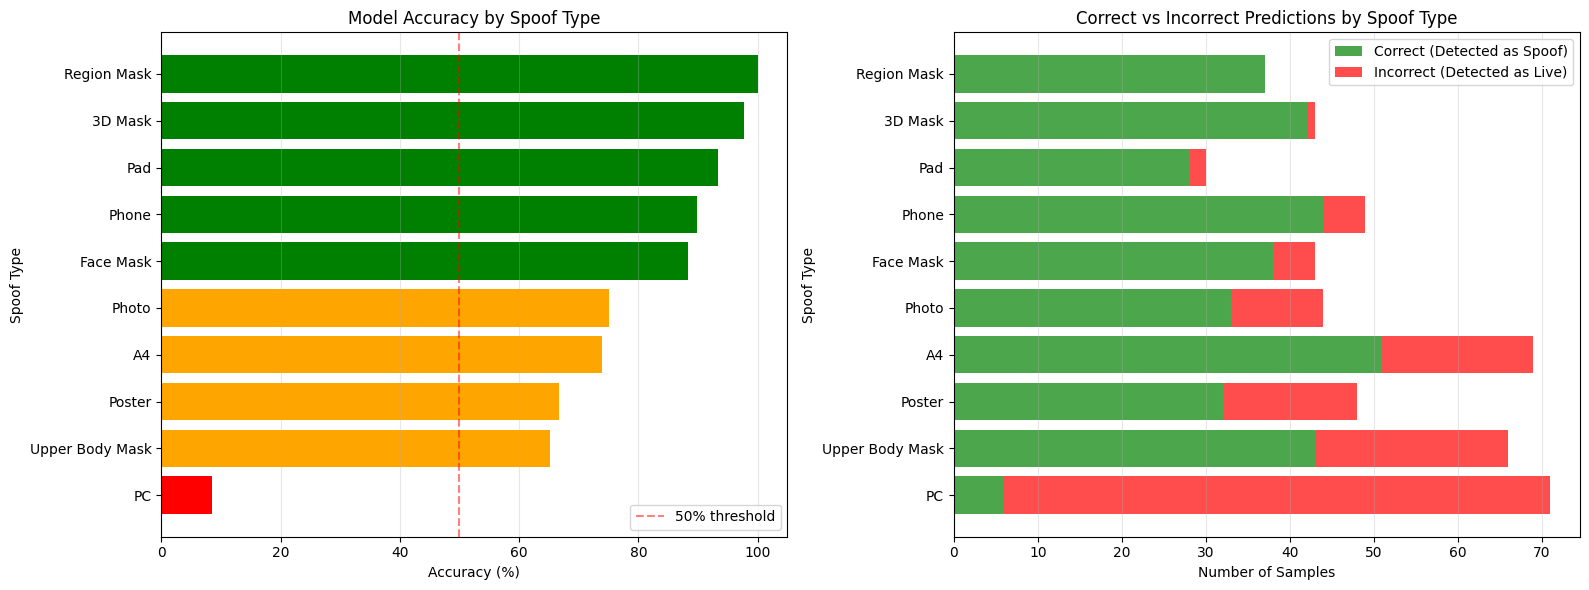


Spoof Type Analysis Results:
     Spoof Type  Type ID  Total  Correct  Incorrect  Accuracy (%)
             PC        7     71        6         65      8.450704
Upper Body Mask        5     66       43         23     65.151515
         Poster        2     48       32         16     66.666667
             A4        3     69       51         18     73.913043
          Photo        1     44       33         11     75.000000
      Face Mask        4     43       38          5     88.372093
          Phone        9     49       44          5     89.795918
            Pad        8     30       28          2     93.333333
        3D Mask       10     43       42          1     97.674419
    Region Mask        6     37       37          0    100.000000


Worst Performing Spoof Types (Accuracy < 70%):
     Spoof Type  Type ID  Total  Correct  Incorrect  Accuracy (%)
             PC        7     71        6         65      8.450704
Upper Body Mask        5     66       43         23     65.1515

In [26]:
spoof_analysis_df, spoof_fig = analyze_spoof_types(
    model=model,
    dataset=small_test_ds,
    device=device,
    val_transforms=gpu_transforms_val
)

In [27]:


save_results(model=model, confusion_matrix_fig=confusion_matrix, train_loss_fig=train_loss_fig, precision_fig=precision_fig, spoof_fig=spoof_fig, params=params)

Saving results to: train_results\train_15


In [28]:


# Run the analysis


In [29]:
# Check a few samples
for i in range(5):
    _, label = small_test_ds[i]
    print(f"Sample {i}: Label = {label.item()} ({'Live' if label.item() == 0 else 'Spoof'})")

Sample 0: Label = 0 (Live)
Sample 1: Label = 1 (Spoof)
Sample 2: Label = 0 (Live)
Sample 3: Label = 1 (Spoof)
Sample 4: Label = 1 (Spoof)


In [30]:
# Test with a known Live sample
img, label = small_test_ds[2]  # Adjust index to find a Live sample
print(f"True label: {'Live' if label == 0 else 'Spoof'}")

img = img.unsqueeze(0).to(device)
img = gpu_transforms_val(img)
output = model(img)
pred = torch.argmax(output, dim=1).item()
print(f"Predicted: {'Live' if pred == 0 else 'Spoof'}")

True label: Live
Predicted: Live


Analyzing spoof type distribution...


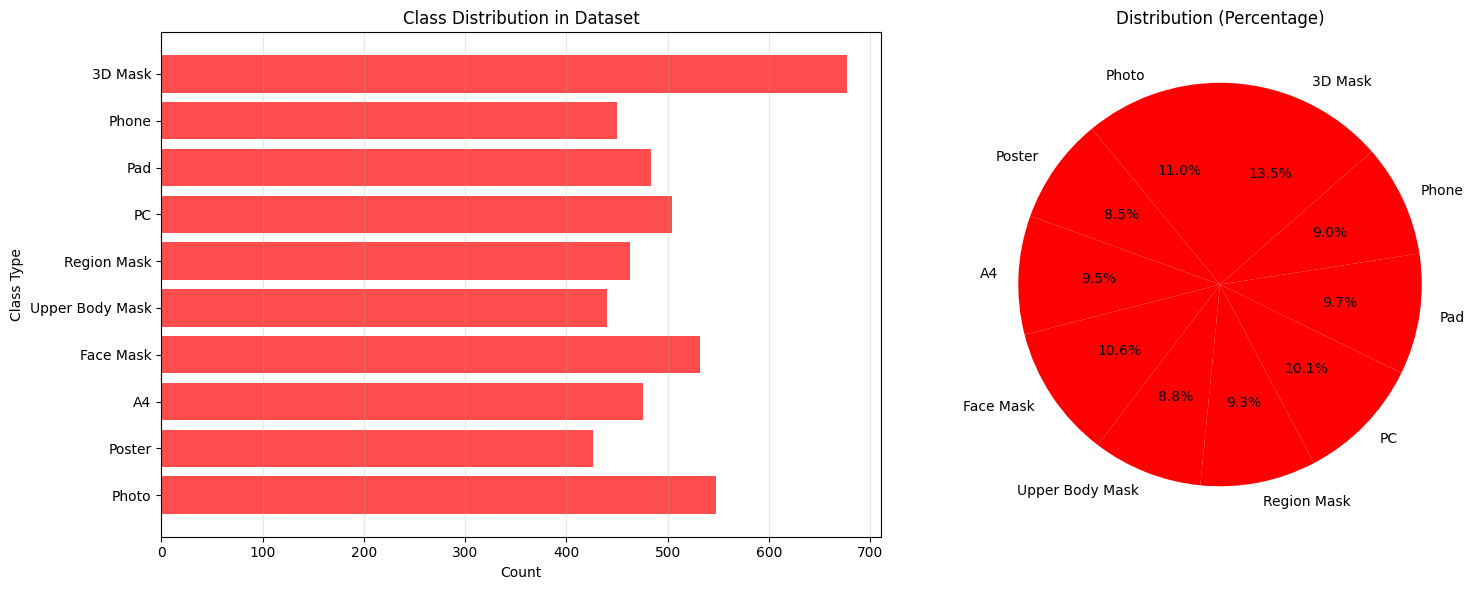


Class Distribution:
     Spoof Type  Type ID  Count  Percentage
          Photo        1    548        5.48
         Poster        2    426        4.26
             A4        3    476        4.76
      Face Mask        4    532        5.32
Upper Body Mask        5    440        4.40
    Region Mask        6    463        4.63
             PC        7    504        5.04
            Pad        8    484        4.84
          Phone        9    450        4.50
        3D Mask       10    677        6.77


In [32]:


# Analyze training dataset distribution
train_dist_df, train_dist_fig = analyze_dataset_spoof_distribution(small_train_ds)

In [43]:
from torchmetrics.classification import (
    MulticlassConfusionMatrix,
    Accuracy,
    Precision,
    Recall,
    F1Score,
    AUROC
)
from spoofdet.spoofing_metric import SpoofingMetric


def evaluate_model(
    model,
    dataloader: DataLoader,
    device: torch.device,
    val_transforms: v2.Compose | None = None,
    threshold: float = 0.5,
):
    confmat = MulticlassConfusionMatrix(num_classes=2).to(device)
    accuracy = Accuracy(task="binary").to(device)
    precision = Precision(task="binary").to(device)
    recall = Recall(task="binary").to(device)
    f1 = F1Score(task="binary").to(device)
    spoof_metric = SpoofingMetric().to(device)
    auroc_metric = AUROC(task='binary').to(device)
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)
            images = val_transforms(images)
            outputs = model(images)
            probs = torch.nn.functional.sigmoid(outputs)
            preds = (probs[:, 1] > threshold).long()

            # Update the metrics with this batch
            confmat.update(preds, labels)
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1.update(preds, labels)
            spoof_metric.update(preds, labels)
            auroc_metric.update(probs[:, 1], labels)

    # Compute the final results
    final_matrix = confmat.compute()
    print("\nConfusion Matrix:")
    print(f"         Predicted Live | Predicted Spoof")
    print(f"Live        {final_matrix[0,0]:>6}     |     {final_matrix[0,1]:>6}")
    print(f"Spoof       {final_matrix[1,0]:>6}     |     {final_matrix[1,1]:>6}")
    acc_val = accuracy.compute()
    prec_val = precision.compute()
    rec_val = recall.compute()
    f1_val = f1.compute()
    spoof_metric_val = spoof_metric.compute()
    auroc_val = auroc_metric.compute()

    # Plot the matrix
    fig, ax = confmat.plot(labels=["Live", "Spoof"])
    ax.set_title("Confusion Matrix: Live vs Spoof")

    # Add metrics as text below the matrix
    metrics_text = (
        f"Accuracy: {acc_val:.4f}   "
        f"Precision: {prec_val:.4f}   "
        f"Recall: {rec_val:.4f}   "
        f"F1 Score: {f1_val:.4f}   "
        f"APCER: {spoof_metric_val['APCER']:.4f}   "
        f"BPCER: {spoof_metric_val['BPCER']:.4f}   "
        f"ACER: {spoof_metric_val['ACER']:.4f}"
    )

    # Position the text at the bottom center of the figure
    fig.text(
        0.5,
        -0.05,
        metrics_text,
        ha="center",
        fontsize=10,
        bbox=dict(
            facecolor="white", alpha=0.8, edgecolor="gray", boxstyle="round,pad=0.5"
        ),
    )

    plt.show()

    print(f"Accuracy: {acc_val:.4f}")
    print(f"Precision: {prec_val:.4f}")
    print(f"Recall:    {rec_val:.4f}")
    print(f"F1 Score:  {f1_val:.4f}")
    print(
        f"Spoofing Metrics: APCER: {spoof_metric_val['APCER']:.4f}, BPCER: {spoof_metric_val['BPCER']:.4f}, ACER: {spoof_metric_val['ACER']:.4f}"
    )
    print(f"AUROC: {auroc_val:.4f}")

    return fig, acc_val, prec_val, rec_val, f1_val, spoof_metric_val
evaluate_model(
    model=model, dataloader=small_test_loader, device=device, val_transforms=gpu_transforms_val, threshold=0.01)


AcceleratorError: CUDA error: out of memory
Search for `cudaErrorMemoryAllocation' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [42]:
from sklearn.metrics import roc_auc_score

# 1. Get your probabilities (Make sure to detach from GPU)
# probs[:, 1] extracts the score for the "Spoof" class

auc_values = []
for img, labels in small_test_loader:
    img, labels = img.to(device), labels.to(device)
    img = gpu_transforms_val(img)

    outputs = model(img)
    probs = torch.nn.functional.sigmoid(outputs)

    y_scores = probs[:, 1].detach().cpu().numpy()
    y_true = labels.detach().cpu().numpy()

# 2. Compute AUC
    auc_value = roc_auc_score(y_true, y_scores)
    auc_values.append(auc_value)

    print(f"ROC AUC Score: {auc_value:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(auc_values) + 1), auc_values, marker='o')
plt.title('ROC AUC Scores per Batch')
plt.xlabel('Batch Number')
plt.ylabel('ROC AUC Score')
plt.ylim(0, 1)
plt.grid()
plt.show()

ROC AUC Score: 0.9688


RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR_HOST_ALLOCATION_FAILED